# SQL Murder Mystery

## Introduction

In [2]:
# import libraries
import pandas as pd
import sqlite3 as sql
from PIL import Image

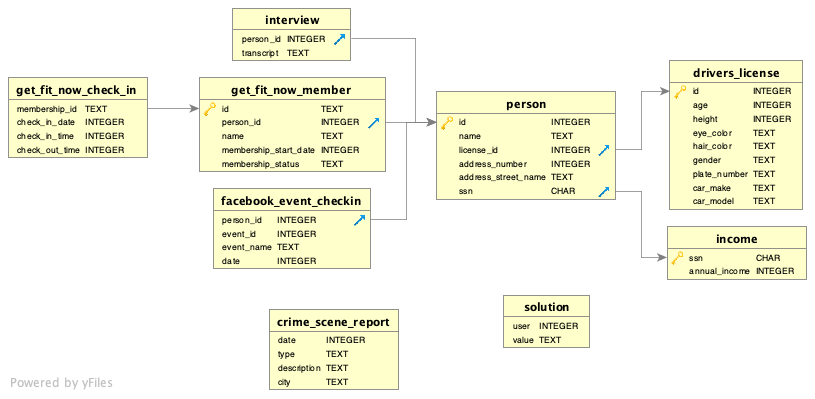

In [3]:
# schema
image = Image.open('database/schema.png')
image

In [4]:
# set dataframe with
pd.set_option("display.max_colwidth", None)

In [5]:
# initialize connection
conn = sql.connect(r"database/sql-murder-mystery.db")

In [6]:
# loof for the murder on Jan 15, 2018
query1= """
SELECT * 
FROM crime_scene_report 
WHERE date = "20180115" 
AND city = "SQL City";

"""
pd.read_sql_query(query1, conn)

,date,type,description,city
0,20180115,assault,"Hamilton: Lee, do you yield? Burr: You shot him in the side! Yes he yields!",SQL City
1,20180115,assault,Report Not Found,SQL City
2,20180115,murder,"Security footage shows that there were 2 witnesses. The first witness lives at the last house on ""Northwestern Dr"". The second witness, named Annabel, lives somewhere on ""Franklin Ave"".",SQL City


There is only one murder report in SQL City on that date. We will need to find both witnesses. 

In [6]:
# find the first witness
query2= """
SELECT * 
FROM person
WHERE address_street_name = "Northwestern Dr"
ORDER BY address_number DESC
LIMIT 1;


"""
pd.read_sql_query(query2, conn)

,id,name,license_id,address_number,address_street_name,ssn
0,14887,Morty Schapiro,118009,4919,Northwestern Dr,111564949


The first witness is Morty Schapiro, and he was located by his address, the last house on Northwestern Dr. 

In [7]:
# find the second witness
query3= """
SELECT * 
FROM person
WHERE address_street_name = "Franklin Ave" 
AND name LIKE "%Annabel%";


"""
pd.read_sql_query(query3, conn)

,id,name,license_id,address_number,address_street_name,ssn
0,16371,Annabel Miller,490173,103,Franklin Ave,318771143


The second witness is Annabel Miller, located by her first name and street name. 

In [8]:
#Get witness testimonies.
query4 = """
SELECT person_id, name, transcript 
FROM interview AS i
JOIN person AS p
ON i.person_id = p.id
WHERE p.id IN (16371, 14887);
"""
pd.read_sql_query(query4, conn)

,person_id,name,transcript
0,14887,Morty Schapiro,"I heard a gunshot and then saw a man run out. He had a ""Get Fit Now Gym"" bag. The membership number on the bag started with ""48Z"". Only gold members have those bags. The man got into a car with a plate that included ""H42W""."
1,16371,Annabel Miller,"I saw the murder happen, and I recognized the killer from my gym when I was working out last week on January the 9th."


The descriptions will help narrow down the suspects to gold members at the gym, with a membership id with '48Z', abd a partial plate. We can narrow down the suspects further by the check in date at the gym. 

In [9]:
#Get witness testimonies
query5 = """
SELECT * 
FROM get_fit_now_check_in
WHERE check_in_date = 20180109
AND membership_id LIKE "%48Z%"; 


"""
pd.read_sql_query(query5, conn)

,membership_id,check_in_date,check_in_time,check_out_time
0,48Z7A,20180109,1600,1730
1,48Z55,20180109,1530,1700


We have two suspects, identified by their membership ids.

In [10]:
# the names of the two suspects 
query6 = """
SELECT membership_id, name
FROM get_fit_now_member AS gfnm
JOIN get_fit_now_check_in AS gfnci
ON gfnm.id = gfnci.membership_id
WHERE gfnci.membership_id IN("48Z7A", "48Z55");
"""
pd.read_sql_query(query6, conn)

,membership_id,name
0,48Z55,Jeremy Bowers
1,48Z7A,Joe Germuska


We were able to uncover the suspects' names by merging the member table with the chenck in table. 

In [11]:
#find the suspect by the partial plate
query7 = """
SELECT dl.id, p.name, plate_number 
FROM drivers_license dl
JOIN person p
ON dl.id = p.license_id
JOIN get_fit_now_member gfn_member
ON p.id = gfn_member.person_id
JOIN get_fit_now_check_in gfn_check_in
ON gfn_member.id = gfn_check_in.membership_id
WHERE gfn_check_in.membership_id IN("48Z7A", "48Z55");

"""
pd.read_sql_query(query7,conn)

,id,name,plate_number
0,423327,Jeremy Bowers,0H42W2


We used the membership id to trace back and find the suspect with the description of the partial plate. We only have one suspect, as it appears that Joe Germuska does not have a vehicle registered in his name. 

In [12]:
# suspects testimony
query8 = """
SELECT person_id, transcript
FROM interview AS i
JOIN person as p
ON i.person_id = p.id
WHERE license_id = 423327;

"""
pd.read_sql_query(query8,conn)

,person_id,transcript
0,67318,"I was hired by a woman with a lot of money. I don't know her name but I know she's around 5'5"" (65"") or 5'7"" (67""). She has red hair and she drives a Tesla Model S. I know that she attended the SQL Symphony Concert 3 times in December 2017.\n"


Now we have the interview of the killer, and he is telling us the description of the woman that hired him. We will use the description to finde her. 

In [28]:
# Finding the females matching the killer's description 
query9 = """
SELECT * 
FROM drivers_license as dl
JOIN person AS p
ON dl.id = p.license_id
WHERE height BETWEEN 65 AND 67
AND hair_color = 'red'
AND car_model = 'Model S'
AND gender = 'female';


"""
pd.read_sql_query(query9,conn)

,id,age,height,eye_color,hair_color,gender,plate_number,car_make,car_model,id,name,license_id,address_number,address_street_name,ssn
0,918773,48,65,black,red,female,917UU3,Tesla,Model S,78881,Red Korb,918773,107,Camerata Dr,961388910
1,291182,65,66,blue,red,female,08CM64,Tesla,Model S,90700,Regina George,291182,332,Maple Ave,337169072
2,202298,68,66,green,red,female,500123,Tesla,Model S,99716,Miranda Priestly,202298,1883,Golden Ave,987756388


We narrowed down the suspected woman to three ids. 

In [34]:
# the people who went to the symphony 3 times in december of 2017
query10 = """
SELECT *
FROM facebook_event_checkin
WHERE event_name = 'SQL Symphony Concert' 
AND date >= 20171201 AND date <= 20171231
GROUP BY person_id
HAVING Count(*)=3;


"""
pd.read_sql_query(query10,conn)

,person_id,event_id,event_name,date
0,24556,1143,SQL Symphony Concert,20171207
1,99716,1143,SQL Symphony Concert,20171206


In [115]:
# the woman that matches the killers description
query11 = """
SELECT * 
FROM person
WHERE id = 99716;

"""
pd.read_sql_query(query11,conn)

,id,name,license_id,address_number,address_street_name,ssn
0,99716,Miranda Priestly,202298,1883,Golden Ave,987756388


We isolated the person that ordered the hit. The police need to arrest Miranda Priestly, who lives at 1883 Golden ave. 

## More Practice Queries

In [48]:
# most common car brands
query13 = """
SELECT COUNT(id) AS count, car_make
FROM drivers_license
GROUP BY car_make
ORDER BY COUNT(id) DESC
LIMIT 20;

"""
pd.read_sql_query(query13, conn)

,count,car_make
0,792,Chevrolet
1,764,Ford
2,570,Toyota
3,508,GMC
4,454,Dodge
5,394,BMW
6,353,Mercedes-Benz
7,335,Nissan
8,316,Lexus
9,313,Mazda


Looking at the most popular car makes in the drivers license table.

In [57]:
# distribution of gender
query14 = """
SELECT COUNT(id) AS count, gender
FROM drivers_license
GROUP BY gender;

"""
pd.read_sql_query(query14, conn)

,count,gender
0,5064,female
1,4943,male


Looking at the distribution of genders. 

In [51]:
# distribution of eye color
query15 = """
SELECT COUNT(eye_color) AS count, eye_color
FROM drivers_license
GROUP BY eye_color
ORDER BY count DESC;

"""
pd.read_sql_query(query15, conn)

,count,eye_color
0,2030,brown
1,2025,blue
2,2017,black
3,1988,green
4,1947,amber


Looking at the distribution of eye color

In [54]:
# average ages of the genders
query16 = """
SELECT AVG(age), gender 
FROM drivers_license
GROUP BY gender;
"""
pd.read_sql_query(query16, conn)

,AVG(age),gender
0,53.061809,female
1,53.319846,male


The Average age of both males and females is the same. 

In [86]:
# number of individuals between 18 and 35
query17= """
SELECT COUNT(id) 
FROM drivers_license
WHERE age BETWEEN 18 AND 35;

"""
pd.read_sql_query(query17, conn)

,COUNT(id)
0,2555


The number of individuals between the ages of 18 and 35.

In [61]:
# the age range of those with drivers license
query18= """
SELECT MAX(age) - MIN(age) AS age_diff
FROM drivers_license;
"""
pd.read_sql_query(query18, conn)

,age_diff
0,71


The age difference of those with a drivers license

In [87]:
# the most common crimes
query19= """
SELECT COUNT(type) AS count, type 
FROM crime_scene_report
GROUP BY type
ORDER BY COUNT(type) DESC;
"""
pd.read_sql_query(query19, conn)

,count,type
0,148,murder
1,148,arson
2,145,assault
3,141,theft
4,135,bribery
5,134,robbery
6,130,fraud
7,130,blackmail
8,117,smuggling


The most common crimes among crime scene reports.

In [85]:
# cities with the most murders
query20= """
SELECT COUNT(type) as count, type, city 
FROM crime_scene_report
WHERE type = 'murder'
GROUP BY city
HAVING count >=3
ORDER BY COUNT(type) DESC;

"""
pd.read_sql_query(query20, conn)

,count,type,city
0,3,murder,Vero Beach
1,3,murder,SQL City
2,3,murder,Madison


The cities with the most murders are Vero Beach, SQL City, and Madison. 

In [80]:
# Cities with the lowest amount of murders
query21= """
SELECT COUNT(type) as count, type, city 
FROM crime_scene_report
WHERE type = 'murder'
GROUP BY city
ORDER BY COUNT(type) ASC
LIMIT 10;

"""
pd.read_sql_query(query21, conn)

,count,type,city
0,1,murder,Akron
1,1,murder,Albany
2,1,murder,Amarillo
3,1,murder,Antioch
4,1,murder,Appleton
5,1,murder,Baltimore
6,1,murder,Billings
7,1,murder,Boise
8,1,murder,Bonita Springs
9,1,murder,Cape Coral


These cities have the lowest reports of murders.

In [84]:
# The cities with the most assaults
query22= """
SELECT COUNT(type) as count, type, city 
FROM crime_scene_report
WHERE type = 'assault'
GROUP BY city
HAVING count >=3
ORDER BY COUNT(type) DESC;

"""
pd.read_sql_query(query22, conn)

,count,type,city
0,3,assault,Sterling Heights
1,3,assault,Portsmouth
2,3,assault,Fort Walton Beach
3,3,assault,Corona


These cities all have the most reports of assault, at 3 reports. 

In [93]:
# the most popular events
query23= """
SELECT COUNT(DISTINCT(person_id)) AS count , event_name
FROM facebook_event_checkin
GROUP BY event_id
HAVING count >=30
ORDER BY count DESC;

"""
pd.read_sql_query(query23, conn)

,count,event_name
0,89,SQL Symphony Concert
1,36,In a five year period we can get one superb programming language. Only\n
2,33,America may be unique in being a country which has leapt from barbarism\n
3,33,"If you think last Tuesday was a drag, wait till you see what happens\n"
4,33,Don't tell any big lies today. Small ones can be just as effective.\n
5,33,-- Groucho Marx\n
6,32,Its monitor loses so totally!\n
7,32,Gandhi: I think it would be a good idea.\n
8,32,Stay away from flying saucers today.\n
9,31,"Diplomacy is the art of saying ""nice doggy"" until you can find a rock.\n"


More people attended the SQL Symphony Concert than any other event. 

In [117]:
# the individuals with the highest annual income
query25= """
SELECT annual_income, p.ssn, p.name
FROM income
JOIN person AS p
ON income.ssn = p.ssn
WHERE annual_income >= 53257.798776
ORDER BY annual_income DESC;

"""
pd.read_sql_query(query25, conn)

,annual_income,ssn,name
0,498500,361660921,Numbers Cranker
1,489800,121635236,Truman Haaker
2,486600,118015315,Felice Prudden
3,476300,541217354,Dianna Eyster
4,475700,313890530,Buena Cosimini
...,...,...,...
3498,53300,438909002,Cathleen Defaber
3499,53300,198975210,Enoch Speach
3500,53300,574574200,Polly Cutright
3501,53300,740135690,Ramon Vinciguerra


Numbers Cranker has the highest annual income, while there are a little over 3,500 people who make more than the mean income. 